# 1 Time-to-event Data Analysis

We want to predict the time to the occurence of a particular event. For example, when a patient will die from disease, when a patient will recover, etc.

## Survival Data

For example, the data "when an electronic device will fail" or "when a patient will die" are typical survival data.

### Skewness

Survival data are generally not symmetric, and tend to positively skewed. Thus we seldom use Gaussian distribution to model the data.

### Censoring

Censoring (删失) is a major concern in survival regression analysis. 

For example, we want to study how long can a patient survive after receiving a heart transplant. And we track the health states of some patients. However, some of the patients have not yet deceased when our study ends at time $C$, and we will not know when they will die (we only know that $T>C$). Then the data are censored.

#### Right Censoring

Right censoring underestimates the occurence time of event. 

For example, the study ends before the event occurs, or we fail to follow up the track of a subject.

#### Left Censoring

Left censoring misses the beginning time of experiment.

For example, we want to find out when a man with bad lifestyle will get cancer. Suppose he sees a doctor once a year and he is diagnosed with cancer in the $T$-th year. Then he gets cancer in $(T-1)\sim T$-th year.

#### Independence

Censoring is sometimes not independent with the time.

For example, we are conducting a new treatment on patients and want to learn the time for patients to recover. But some patients quit the treatment before the study ends, leading to right censoring. This might be due to the chance that the patient is getting good, which is not independent with the time.

<br>

We will assume independent censoring in the following course.

## Survival Function

Let $T$ be the time of the event occurs, and it follows some distribution $\mathbb P$. We assume the distribution is continuous. Define $S(t)$ by 

$$S(t) = 1 - \mathbb P(T\leqslant t)=\mathbb P(T>t),$$

which is the complement of C.D.F., and we call $S(t)$ the survival function.

Clearly, $S$ is nonincreasing and $S(0)=1$ and $S(+\infty)=0$.

### Hazard Function

Define the hazard function $\lambda(t)$ by 

$$\lambda(t) = \lim_{h\rightarrow 0}\frac 1h\mathbb P(t\leqslant T<t+h|T\geqslant t),$$

which is the conditional probability density that the event occurs in the coming moment.


**Theorem** $\lambda(t)  = f(t)/S(t)= -\frac{\partial }{\partial t}\log S(t)$ where $f$ is the probability density function.

<br>

**Example** Exponential family has constant hazard, and is said to be "memoryless".

**Proof** $S(t) = e^{-\lambda t}$ and thus $\lambda(t) = -\frac{\partial}{\partial t}(-\lambda t)=\lambda$.

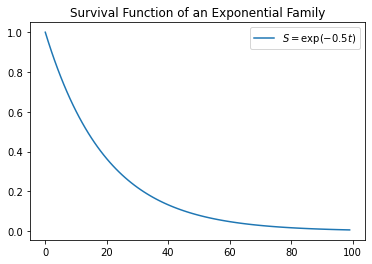

In [7]:
from matplotlib import pyplot as plt
import numpy as np

r = .5
survival = np.exp(np.linspace(0, 10, 100) * (-r))
plt.plot(survival)
plt.legend(['$S = \\exp(-%.1ft)$'%r])
plt.title('Survival Function of an Exponential Family')
plt.show()

## Kaplan-Meier Estimation

For example if we have observed $21$ pieces of survival data

$$t = 6, 6, 6, 6, 7, 9, 10, 10, 11, 13, 16, 17, 19, 20, 22, 23, 25, 32, 32, 34, 35.$$

Then we can estimate, for example, $\hat S(9) =\hat{ \mathbb P}(t>9) = \frac{15}{21}\approx .7143$.

<br>


However, if we get censored data like following (with right-censored data marked with $\cdot ^+$), things get different.

$$t = 6^+, 6, 6, 6, 7, 9^+, 10^+, 10, 11^+, 13, 16, 17^+,19^+, 20^+, 22, 23, 25^+, 32^+, 32^+, 34^+, 35^+.$$


This is because we do not know the true values of the censored data (but we know that they are no smaller than the observed values).

### Kaplan-Meier Estimation

[Kaplan-Meier (KM) method](https://handwiki.org/wiki/Kaplan%E2%80%93Meier_estimator) handles censored data by recurrsion. Assume all events all happen on integer timestamps, then

$$\hat{\mathbb P}(T> t)=\hat{\mathbb P}(T> t-1)\cdot \hat{\mathbb P}(T> t|T>  t-1)=\hat{\mathbb P}(T> t-1)\cdot \left[1 - \hat{\mathbb P}(T=t|T>t-1)\right].$$

This is a recurrsive formula, and we can also take the product to yield:

$$\hat S(t) = \prod_{t_j<t}\left[ 1 - \frac{d_j}{r_j}\right]$$

where $d_j$ is the number of (uncensored) events at time $t_j$ while $r_j$ is the number of survivors $\geqslant t_j$. The method is also known as the product-limit method.

<br>

For instance in the data above, we have 

$$\hat{S}_{\rm KM}(9)=\left(1 - \frac {3}{21}\right)\left(1 - \frac {1}{17}\right)\left(1 - \frac {0}{16}\right)=\frac{96}{119}\approx .8067$$

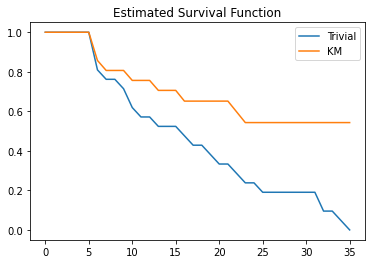

In [56]:
import numpy as np
from matplotlib import pyplot as plt

data = np.array([6, 6, 6, 6, 7, 9, 10, 10, 11, 13, 16, 17, 19, 20, 22, 23, 25, 32, 32, 34, 35])
censor = np.array([1,0,0,0,0,1,1,0,1,0,0,1,1,1,0,0,1,1,1,1,1])

def trivial(data, censor = None):
    timeline = np.zeros(data.max() + 1)
    for i in data:
        timeline[:i] += 1  # add count to time <= i
    return timeline / data.size

def KM(data, censor):
    timeline, prob = np.zeros(data.max() + 1), 1.
    count_cs = np.unique(np.extract(1^censor, data), return_counts = True)
    count_all = np.unique(data, return_counts = True)
    t, r = 0, data.size
    for v, d, c2 in zip(count_cs[0], count_cs[1], count_all[1]):
        while v > t:
            timeline[t] = prob
            t += 1
        prob *= 1 - d / r
        r -= c2 # move on to the next timestamp
    timeline[t:] = prob
    return timeline

plt.plot(trivial(data))
plt.plot(KM(data, censor))
plt.legend(['Trivial', 'KM'])
plt.title('Estimated Survival Function')
plt.show()

### Greenwoods' Formula

Greenwoods formula estimates the variance of the KM estimator. It suggests that 

$${\rm Var}(\hat S(t)) \approx [\hat S(t)]^2 \sum_{t_j\leqslant t}\frac{d_j}{(r_j -d_j)r_j}$$


where $d_j$ is the number of (uncensored) events at time $t_j$ while $r_j$ is the number of survivors $\geqslant t_j$. 

**Proof** We use the following lemma:

* Lemma: (Delta method) if $a_n(X_n - \mu)\rightarrow_d N(0,\sigma^2)$ and $a_n>0$ and $a_n\rightarrow \infty$. Then $a_n[g(X_n) - g(\mu)]\rightarrow_d N(0,g'(\mu)^2\sigma^2)$ if $g$ is differentiable at $\mu$.

Back to the main problem, first we compute the asymptotic property of $\log \hat S(t)$.

$$\log \hat S(t) = \sum_{t_j\leqslant t}\log \left[1 - \frac{d_j}{r_j}\right].$$

Note that $d_j$ approximately follows a binomial distribution $B(d_j,p)$ with $\hat p = \frac{d_j}{r_j}$. If we **assume** that $d_j/r_j$ are (asymptotically / approximately) independent, then

$$ {\rm Var}(\log \hat S(t)) \approx  \sum_{t_j\leqslant t}{\rm Var}\left\{\log \left[1 - \frac{d_j}{r_j}\right]\right\}.$$

When $d_j\rightarrow\infty$, $\sqrt {\frac{r_j}{p(1-p)}}(\frac{d_j}{r_j} -p)\rightarrow_d N(0,1)$ and  the lemma tells us that $\sqrt {\frac{r_j}{p(1-p)}}(\log (1 - \frac{d_j}{r_j})) \rightarrow_d N(0,\frac{1}{(1-p)^2})$. Therefore, 

$${\rm Var}\left[\log (1 - \frac{r_j}{d_j})\right] = \frac{p}{(1-p)\cdot r_j}\approx \frac{\hat p}{(1 - \hat p)r_j} = \frac{d_j}{(r_j - d_j)r_j}.$$

Finally, applying the lemma on $\log \hat S(t)$ (just assume it is right) claims that 

$${\rm Var}\left[\log\hat  S(t)\right]\approx \frac{1}{ [\hat S(t)]^2} {\rm Var}(\hat S(t)),$$

leading to the desired result.

### Log-log Approach

We can give an approximate confidence bound for $S(t)$ by $\hat S(t)\pm z_{1-\frac  \alpha 2}\sqrt{\widehat{\rm Var}(\hat S(t))}$. However, it is sometimes not good because the bound might exceed $[0,1]$ while we know for sure that $S(t)\in [0,1]$.

Instead we can first give an confidence bound for $L(t)=\log(-\log S(t))\in (-\infty, \infty)$ and then transform it back: $S(t) = \exp (-\exp(L(t)))\in (0,1)$. This is the log-log approach. Concretely,

**Theorem** Using the Delta method on $\log \hat S(t)$ we yield

$${\rm Var}(\hat L(t))\approx \frac{1}{[\log \hat S(t)]^2}\sum_{t_j\leqslant t} \frac{d_j}{(r_j - d_j) r_j}$$

and, if $L(t)\in (\hat L(t) - A,\hat L(t)+A)$ is a confidence bound for $L$, then the confidence bound for $S$ should be

$$S(t) \in \left( [\hat S(t)]^{e^A}, [\hat S(t)]^{e^{-A}}\right)$$

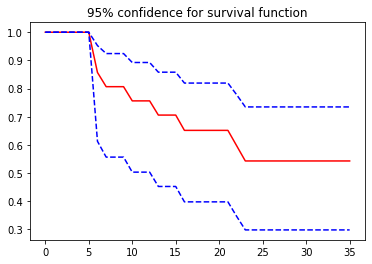

In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.array([6, 6, 6, 6, 7, 9, 10, 10, 11, 13, 16, 17, 19, 20, 22, 23, 25, 32, 32, 34, 35])
censor = np.array([1,0,0,0,0,1,1,0,1,0,0,1,1,1,0,0,1,1,1,1,1])

def KM_bound(data, censor, zz = 2.):
    """
    Parameters
    -------
    data  : numpy integer array, shape (n,), the survival data
    censor: numpy bool array, shape (n,), indicating whether a datum is censored
    zz    : half bandwidth of std, defaults to +- 2 std
    """
    timeline, prob = np.zeros(data.max() + 1), 1.
    bound1, bound2 = timeline.copy(), timeline.copy()
    count_cs = np.unique(np.extract(1^censor, data), return_counts = True)
    count_all = np.unique(data, return_counts = True)
    t, r, s, bd1, bd2 = 0, data.size, 0, 1, 1
    for v, d, c2 in zip(count_cs[0], count_cs[1], count_all[1]):
        while v > t:
            timeline[t] = prob
            bound1[t], bound2[t] = bd1, bd2
            t += 1
        prob *= 1 - d / r
        s += d / (r - d) / r # accumulation
        standard_error = np.sqrt(s / np.log(prob)**2)
        bd1, bd2 = prob ** np.exp(standard_error*zz), prob ** np.exp(-standard_error*zz)
        r -= c2 # move on to the next timestamp
    timeline[t:] = prob
    bound1[t:], bound2[t:] = bd1, bd2
    return timeline, bound1, bound2

[plt.plot(y, color) for y, color in zip(KM_bound(data, censor),('r','b--','b--'))]
plt.title('95% confidence for survival function')
plt.show()

### Nelson-Aalen Estimator

There are other estimators for the survival function besides the KM estimator. For example, the [Nelson-Aalen estimator](https://handwiki.org/wiki/Nelson%E2%80%93Aalen_estimator).

$$-\log S(t)\approx \sum_{t_j\leqslant t}\frac{d_j}{r_j}$$

where $d_j$ is the number of (uncensored) events at time $t_j$ while $r_j$ is the number of survivors $\geqslant t_j$. 

## Logrank Test

Logrank test is a hypothesis testing to compare whether two survival functions have significant difference. For example we want to test whether a new treatment has an impact on the survival time. It is also called the Cox-Mantel test.

At each timestamp when the event happens, we construct a $2\times 2$ contigency table to conduct the chi-squared test. Suppose the timestamp is $t_1<\dotsc<t_K$, for $1\leqslant j\leqslant K$ we count the number of occurring events in two collections of survival data at time $t_j$ and have the following table:

|Index|Occurs at $t_j$|Survivors till $t_j$|Total|
|---|---|---|---|
|$0$|$d_{0j}$|$r_{0j}-d_{0j}$|$r_{0j}$|
|$1$|$d_{1j}$|$r_{1j}-d_{1j}$|$r_{1j}$|
|Total|$d_{ j}$|$r_{ j}-d_{ j}$|$r_{j}$|

Assuming $H_0$: two survival functions are identical, then the test statistic is then given by 

$$\chi_{\rm logrank}^2 = \frac{[\sum_{j=1}^K(d_{0j} - \frac{r_{0j}}{r_j}d_j)]^2}{\sum_{j=1}^K \frac{r_{0j}r_{1j}d_j(r_j - d_j)}{r_j^2(r_j - 1)}}\sim \chi_1^2.$$


Note: the test statistic is symmetric with respect to the index $0$ and $1$ since $d_{0j} - \frac{r_{0j}}{r_j}d_j= -(d_{1j} - \frac{r_{1j}}{r_j}d_j)$.


### Test for Trend

For test for multiple survival functions, e.g. how different age groups impact on the survival data, we should take the impact of trend into consideration.